In [234]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
import time

# to print plots inline
%matplotlib inline

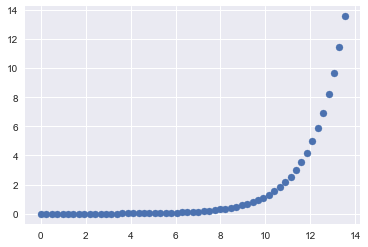

In [235]:
# specify parameters
alpha_k = 0.29715
alpha_l = 0.65
delta = 0.154
psi = 0.03
w = 0.7
r= 0.04
#replaced z with 1 for the lower bound. (should we choose z = smallest point in zgrid instead?)

betafirm = (1 / (1 + r))

dens = 1
# put in bounds here for the capital stock space
kstar = ((((1 / betafirm - 1 + delta) * ((w / alpha_l) **
                                         (alpha_l / (1 - alpha_l)))) /
         (alpha_k * (1 ** (1 / (1 - alpha_l))))) **
         ((1 - alpha_l) / (alpha_k + alpha_l - 1)))
kbar = 2*kstar
lb_k = 0.001
ub_k = kbar
krat = np.log(lb_k / ub_k)
numb = np.ceil(krat / np.log(1 - delta))
K = np.zeros(int(numb * dens))
# we'll create in a way where we pin down the upper bound - since
# the distance will be small near the lower bound, we'll miss that by little
for j in range(int(numb * dens)):
    K[j] = ub_k * (1 - delta) ** (j / dens)
kvec = K[::-1]
sizek = kvec.shape[0]

k_linear = np.linspace(lb_k, ub_k, num=sizek)
plt.scatter(k_linear, kvec)

Theoretical sigma_z =  0.3280264242800136
Simulated sigma_z =  0.327990421648
Cut-off values =  [       -inf -0.40040229 -0.25084498 -0.14128994 -0.04582867  0.04582867
  0.14128994  0.25084498  0.40040229         inf]
Grid points =  [-0.55913938 -0.32004072 -0.19425291 -0.09290094  0.          0.09290094
  0.19425291  0.32004072  0.55913938]
Transition matrix =  [[  5.34646999e-01   2.33099908e-01   1.19241334e-01   6.16948412e-02
    3.06368282e-02   1.38694209e-02   5.27307457e-03   1.39972319e-03
    1.37871226e-04]
 [  2.33099908e-01   2.53066831e-01   1.95990939e-01   1.38221479e-01
    8.98690322e-02   5.26608516e-02   2.62024217e-02   9.48881413e-03
    1.39972319e-03]
 [  1.19241334e-01   1.95990939e-01   1.96744233e-01   1.70765394e-01
    1.33994761e-01   9.44950201e-02   5.72928238e-02   2.62024217e-02
    5.27307457e-03]
 [  6.16948412e-02   1.38221479e-01   1.70765394e-01   1.75481409e-01
    1.60693238e-01   1.32118347e-01   9.44950201e-02   5.26608516e-02
    1.38694209

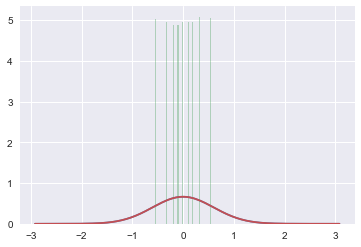

In [236]:
#AR APPROXIMATION

# import packages
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# to print plots inline
%matplotlib inline

# set out parameters
rho = 0.7605
mu = 0.0
sigma_eps = 0.213
sigma_z = sigma_eps/ ((1-rho**2)**(1/2))

# draw our shocks
num_draws = 100000 # number of shocks to draw
eps = np.random.normal(0.0, sigma_eps, size=(num_draws))

# Compute z
z = np.empty(num_draws)
z[0] = 0.0 + eps[0]
for i in range(1, num_draws):
    z[i] = rho * z[i - 1] + (1 - rho) * mu + eps[i]
    
############################################################################
# plot distribution of z
# sns.distplot(z, hist=False)
sns.kdeplot(np.array(z), bw=0.5)

# theory says:
sigma_z = sigma_eps / ((1 - rho ** 2) ** (1 / 2))
print('Theoretical sigma_z = ', sigma_z)

# from our simulation:
sigma_z_simul = z.std()
print('Simulated sigma_z = ', sigma_z_simul)

# import packages
from scipy.stats import norm

# Compute cut-off values
N = 9  # number of grid points (will have one more cut-off point than this)
z_cutoffs = (sigma_z * norm.ppf(np.arange(N + 1) / N)) + mu
print('Cut-off values = ', z_cutoffs)

# compute grid points for z
z_grid = ((N * sigma_z * (norm.pdf((z_cutoffs[:-1] - mu) / sigma_z)
                              - norm.pdf((z_cutoffs[1:] - mu) / sigma_z)))
              + mu)
print('Grid points = ', z_grid)

############################################################################
# import packages
import scipy.integrate as integrate

# define function that we will integrate
def integrand(x, sigma_z, sigma_eps, rho, mu, z_j, z_jp1):
    val = (np.exp((-1 * ((x - mu) ** 2)) / (2 * (sigma_z ** 2)))
            * (norm.cdf((z_jp1 - (mu * (1 - rho)) - (rho * x)) / sigma_eps)
               - norm.cdf((z_j - (mu * (1 - rho)) - (rho * x)) / sigma_eps)))
    
    return val

# compute transition probabilities
pi = np.empty((N, N))
for i in range(N):
    for j in range(N):
        results = integrate.quad(integrand, z_cutoffs[i], z_cutoffs[i + 1],
                                 args = (sigma_z, sigma_eps, rho, mu,
                                         z_cutoffs[j], z_cutoffs[j + 1]))
        pi[i,j] = (N / np.sqrt(2 * np.pi * sigma_z ** 2)) * results[0]
        
print('Transition matrix = ', pi)
# print('pi sums = ', pi.sum(axis=0), pi.sum(axis=1))

############################################################################
# Simulate the Markov process - will make this a function so can call later
def sim_markov(z_grid, pi, num_draws):
    # draw some random numbers on [0, 1]
    u = np.random.uniform(size=num_draws)

    # Do simulations
    z_discrete = np.empty(num_draws)  # this will be a vector of values 
    # we land on in the discretized grid for z
    N = z_grid.shape[0]
    oldind = int(np.ceil((N - 1) / 2)) # set initial value to median of grid
    z_discrete[0] = z_grid[oldind]  
    for i in range(1, num_draws):
        sum_p = 0
        ind = 0
        while sum_p < u[i]:
            sum_p = sum_p + pi[ind, oldind]
#             print('inds =  ', ind, oldind)
            ind += 1
        if ind > 0:
            ind -= 1
        z_discrete[i] = z_grid[ind]
        oldind = ind
                            
    return z_discrete


# Call simulation function to get simulated values
z_discrete = sim_markov(z_grid, np.transpose(pi), num_draws)
                            
                            
# Plot AR(1) and Markov approximation
sns.distplot(z_discrete, hist=True, kde=False, norm_hist=True)
sns.kdeplot(np.array(z), bw=0.5)

In [237]:
# operating profits, op
op = np.zeros((9, 57))
z_grid_exp = np.exp(z_grid)
for i in range(9):
    for j in range(57):
        op[i, j] = (1- alpha_l)*((alpha_l/w)**(alpha_l/(1-alpha_l)))*(kvec[j]**(alpha_k/(1-alpha_l)))*(z_grid_exp[i]**(1/(1-alpha_l)))

        
# firm cash flow, e if invest
e = np.zeros((N, sizek, sizek)) #N = 9
for h in range(N):
    for i in range(sizek):
        for j in range(sizek):
                e[h, i, j] = op[h, i] - kvec[j] + ((1 - delta) * kvec[i]) - psi * kvec[i]
                

In [238]:
VFtol = 1e-6
VFdist = 7.0
VFmaxiter = 3000
V = np.zeros((N,sizek)) # initial guess at value function
Vmat = np.zeros((N, sizek, sizek))  # initialize Vmat matrix, which is now 3D (z,k,k')
#Vstore = np.zeros((sizek, VFmaxiter))  # initialize Vstore array
VFiter = 1
start_time = time.clock()

In [239]:
print("We set the k grid s.t. k_i = (1-delta)^{1/dens}K_i+1, because if I =0, then K' = (1-delta)K. \
Thus we can use the same V matrix whether the firm invests or not because the K-grid is appropriate for either case.")

while VFdist > VFtol and VFiter < VFmaxiter:
    
    TV = V
    V = pi @ V
    V_nc = np.copy(V)
    
    for h in range(N):  #loop over z
        for i in range(sizek):  # loop over k
            if i == 0:
                V_nc[h, i] = op[h, i] + betafirm * V[h, i]
            else:
                V_nc[h, i] = op[h, i] + betafirm * V[h, i - dens]

    PF_nc = np.copy(PF)
    #if don't invest, then index for k' is just (index for k) - dens
    for i in range(N):
        for j in range(sizek):
            if PF[i, j] > 0:
                PF[i, j] = PF[i, j] - dens
    
    for h in range(N):  #loop over z
        for i in range(sizek):  # loop over k
            for j in range(sizek):  # loop over k'
                Vmat[h, i, j] = e[h, i, j] + betafirm * V[h, j]
    
    V = Vmat.max(axis=2)  
    PF = np.argmax(Vmat, axis=2) 
    
    for i in range(N):
        for j in range(sizek):
            V[i, j] = max(V[i, j], V_nc[i, j])
            if V[i, j] == V_nc[i, j]:
                PF[i, j] = PF_nc[i, j]
                     
    VFdist = (np.absolute(V - TV)).max()  # check distance between value
    # function for this iteration and value function from past iteration
    VFiter += 1

VFI_time = time.clock() - start_time
if VFiter < VFmaxiter:
    print('Value function converged after this many iterations:', VFiter)
else:
    print('Value function did not converge')
print('VFI took ', VFI_time, ' seconds to solve')


VF = V  # solution to the functional equation

We set the k grid s.t. k_i = (1-delta)^{1/dens}K_i+1, because if I =0, then K' = (1-delta)K. Thus we can use the same V matrix whether the firm invests or not because the K-grid is appropriate for either case.
Value function converged after this many iterations: 368
VFI took  11.340215999999998  seconds to solve


In [240]:
'''
------------------------------------------------------------------------
Find optimal capital and investment policy functions
------------------------------------------------------------------------
optK = (sizek,) vector, optimal choice of k' for each k
optI = (sizek,) vector, optimal choice of investment for each k
------------------------------------------------------------------------
'''
optK = kvec[PF]
optI = optK - (1 - delta) * kvec

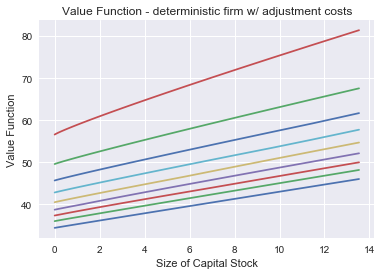

In [241]:
for i in range(9):
    plt.plot(kvec, VF[i])
    plt.xlabel('Size of Capital Stock')
    plt.ylabel('Value Function')
    plt.title('Value Function - deterministic firm w/ adjustment costs')

plt.show()

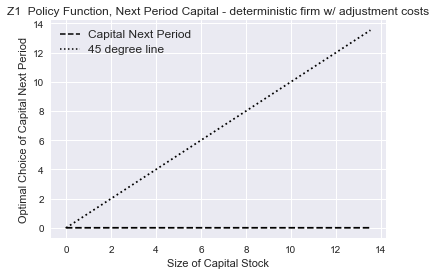

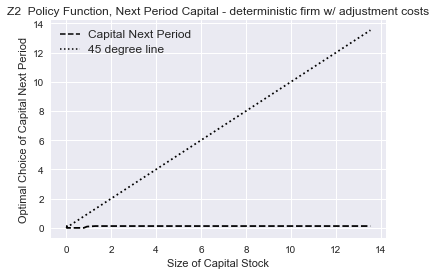

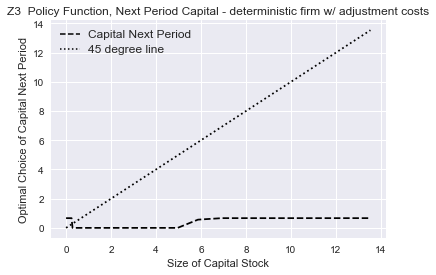

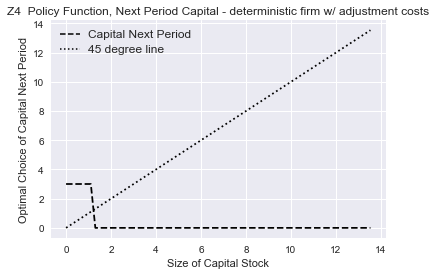

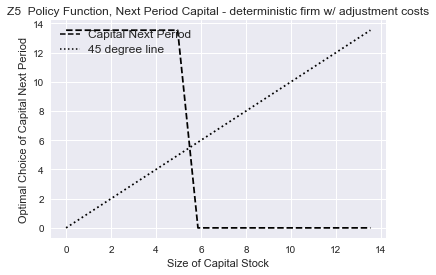

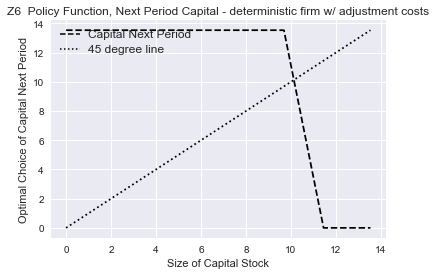

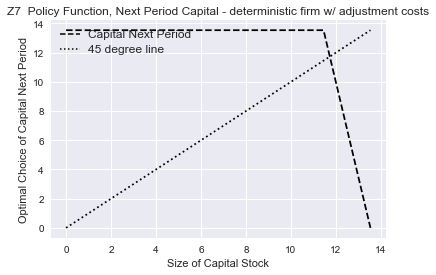

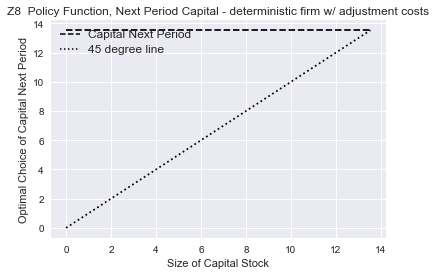

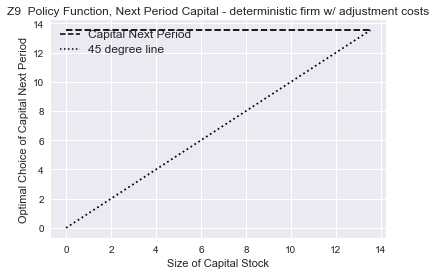

In [242]:
# Plot optimal capital stock rule as a function of firm size
for i in range(len(optK)):
    fig, ax = plt.subplots()
    ax.plot(kvec, optK[i], 'k--', label='Capital Next Period')
    ax.plot(kvec, kvec, 'k:', label='45 degree line')
    # Now add the legend with some customizations.
    legend = ax.legend(loc='upper left', shadow=True)


    for label in legend.get_texts():
        label.set_fontsize('large')
    for label in legend.get_lines():
        label.set_linewidth(1.5)  # the legend line width

    # The frame is matplotlib.patches.Rectangle instance surrounding the legend.
    frame = legend.get_frame()
    frame.set_facecolor('0.90')

    # Set the fontsize
    plt.xlabel('Size of Capital Stock')
    plt.ylabel('Optimal Choice of Capital Next Period')
    plt.title("Z" + str(i+1) + "  "+ 'Policy Function, Next Period Capital - deterministic firm w/ ' +
              'adjustment costs')
    


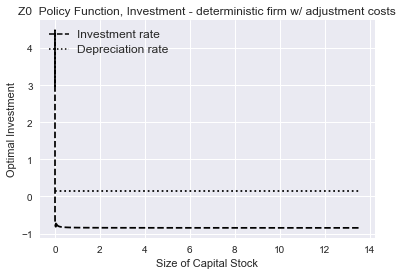

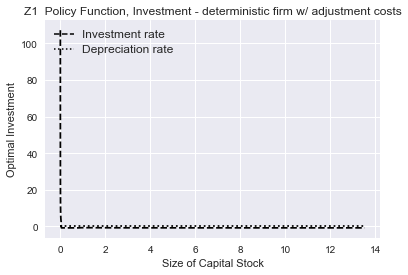

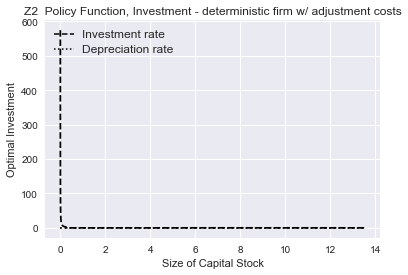

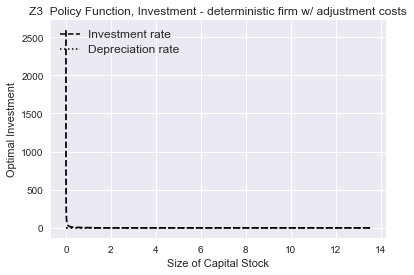

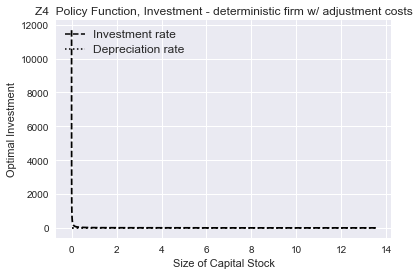

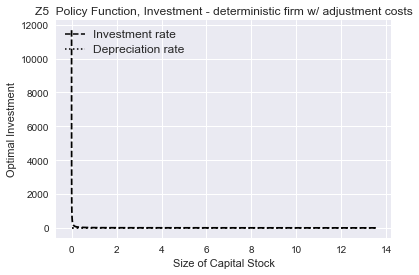

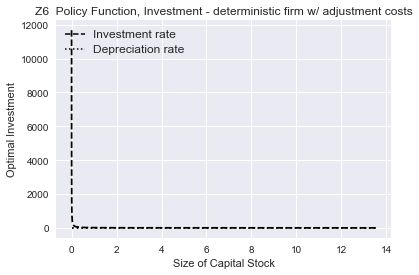

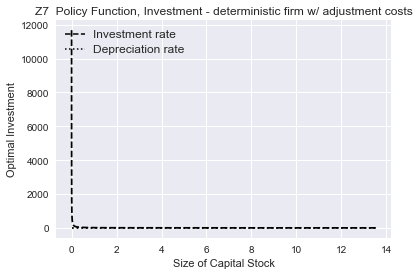

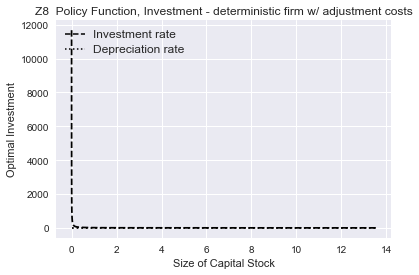

In [243]:

# Plot investment rule as a function of firm size
for i in range(len(optI)):
    fig, ax = plt.subplots()
    ax.plot(kvec, (optI[i]/kvec), 'k--', label='Investment rate')
    ax.plot(kvec, (np.ones(sizek)*delta), 'k:', label='Depreciation rate')
    # Now add the legend with some customizations.
    legend = ax.legend(loc='upper left', shadow=True)
    # The frame is matplotlib.patches.Rectangle instance surrounding the legend.
    frame = legend.get_frame()
    frame.set_facecolor('0.90')
    # Set the fontsize
    for label in legend.get_texts():
        label.set_fontsize('large')
    for label in legend.get_lines():
        label.set_linewidth(1.5)  # the legend line width
    plt.xlabel('Size of Capital Stock')
    plt.ylabel('Optimal Investment')
    plt.title("Z" + str(i) + "  "+ 'Policy Function, Investment - deterministic firm w/ adjustment ' +
              'costs')
